In [60]:
%%capture
#capture suppresses the install output of the cell to increase readability 

#INSTALLS & IMPORTS
!pip install pytrends
!pip install lingua-language-detector
!pip install openpyxl
!pip install seaborn
!pip install scipy

import scipy.stats as stats                                                #Import scipy
import warnings                                                            #Import warnings   
import pandas as pd                                                        #Import pandas
import numpy as np                                                         #Import numpy
import re                                                                  #Import regex for string analysis
from lingua import Language, LanguageDetectorBuilder                       #Import Lingua for language detection
from pytrends.request import TrendReq                                      #Import pytrends
from datetime import datetime                                              #Import datetime
import seaborn as sns                                                      #Import seaborn
import matplotlib.pyplot as plt                                            #Import matplotlib

warnings.simplefilter(action='ignore', category=FutureWarning)             #Removes futurewarning whenever code is run
pd.set_option('display.max_rows', None)                                    #Pandas row options
pd.set_option('max_colwidth', 1000)                                        #Pandas column options
detector = LanguageDetectorBuilder.from_languages(Language.ENGLISH,Language.INDONESIAN).build() #Build detector with English & Indo

     ---------------------------------------- 0.0/60.4 kB ? eta -:--:--
     --------------------------------- ------ 51.2/60.4 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 60.4/60.4 kB 1.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/43.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/43.7 MB 3.6 MB/s eta 0:00:13
    --------------------------------------- 0.9/43.7 MB 11.2 MB/s eta 0:00:04
   -- ------------------------------------- 2.7/43.7 MB 21.2 MB/s eta 0:00:02
   -- ------------------------------------- 3.1/43.7 MB 20.1 MB/s eta 0:00:03
   -- ------------------------------------- 3.1/43.7 MB 20.1 MB/s eta 0:00:03
   -- ------------------------------------- 3.1/43.7 MB 20.1 MB/s eta 0:00:03
   -- ------------------------------------- 3.2/43.7 MB 10.3 MB/s eta 0:00:04
   -- ------------------------------------- 3.2/43.7 MB 10.3 MB/s eta 0:00:04
   -- ------------------------------------- 3.2/43.7 MB 10.3 MB/s eta 0:00:

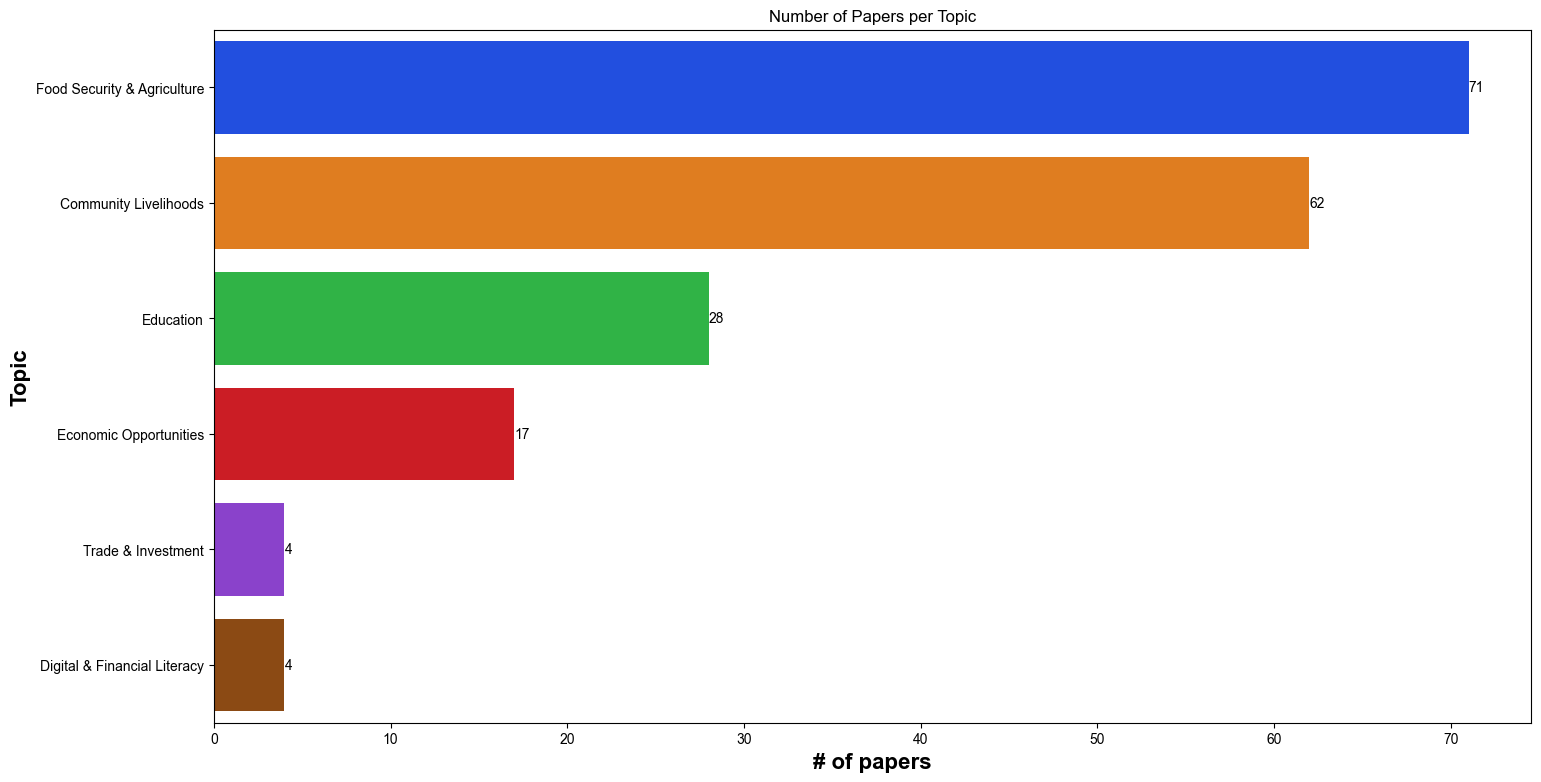

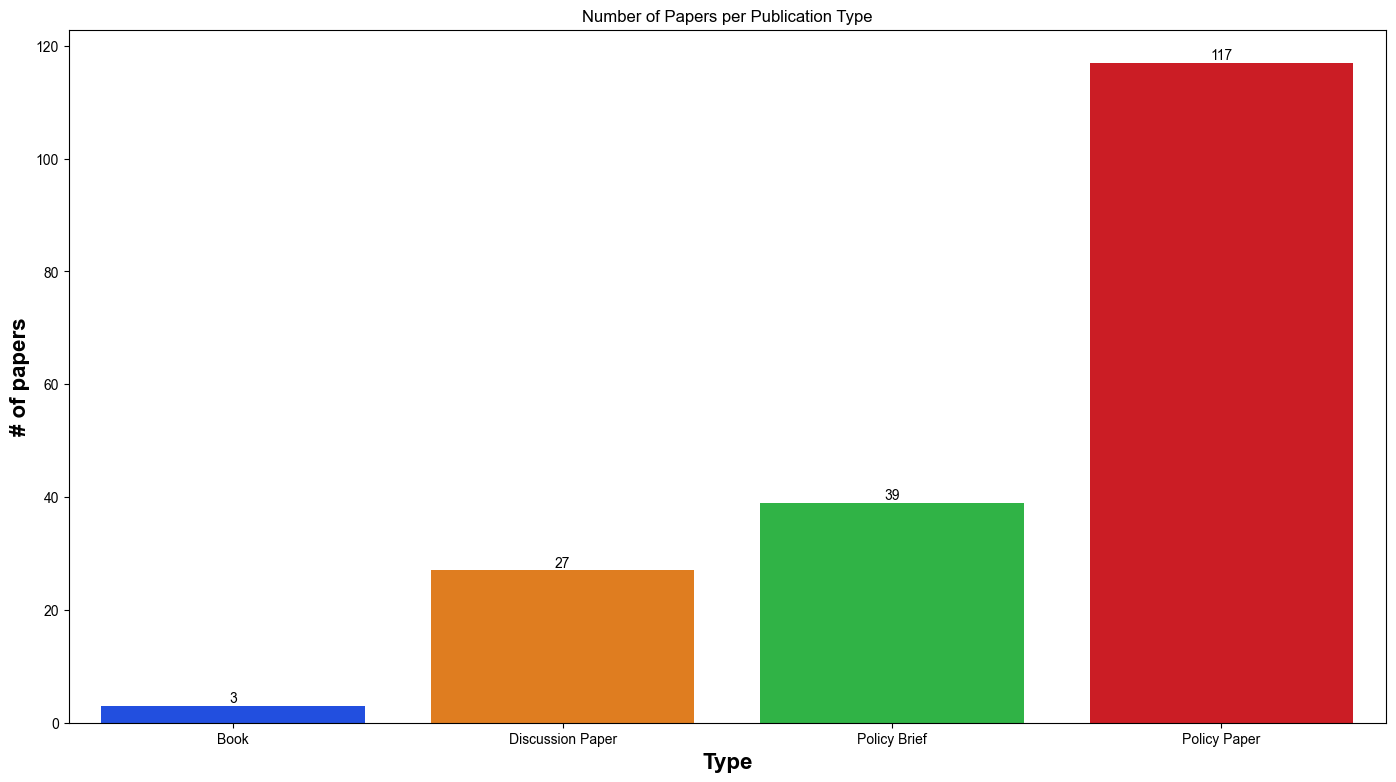

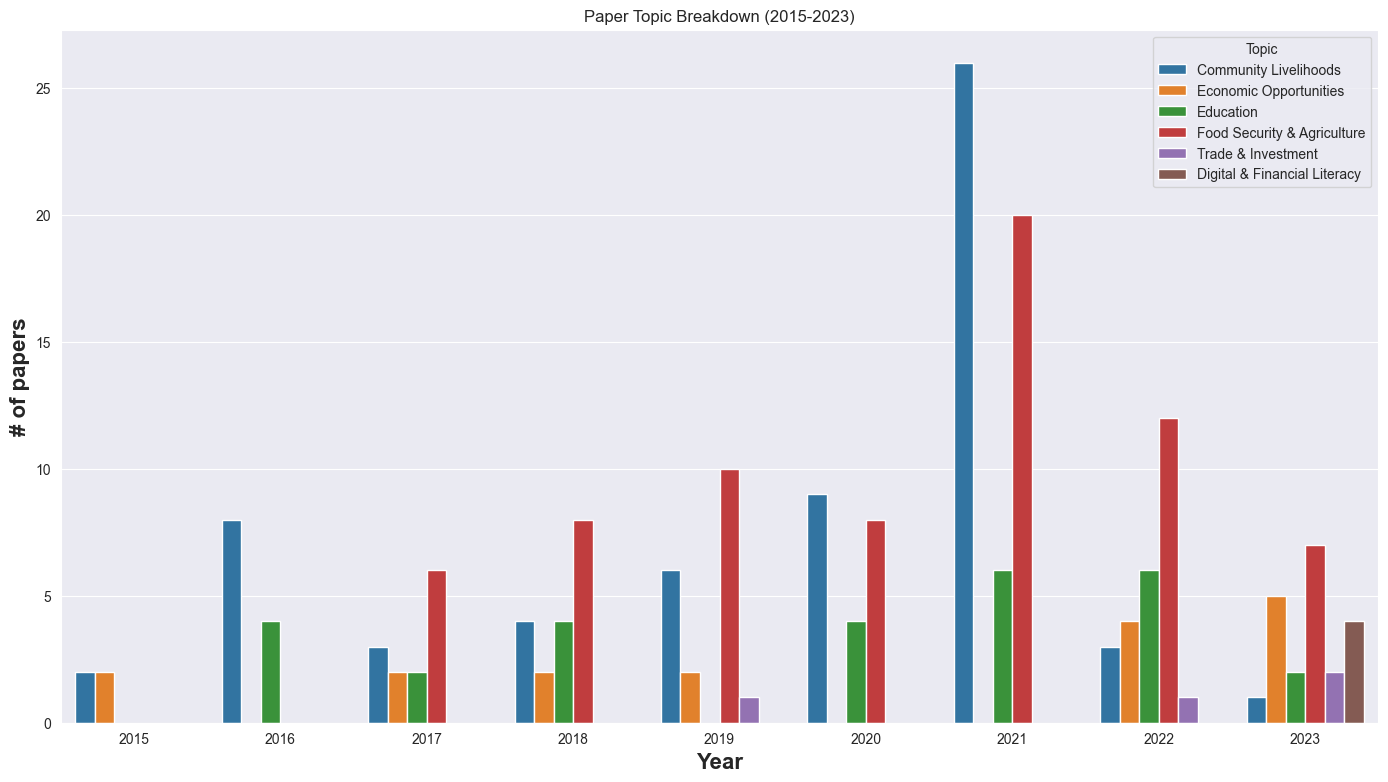

In [3]:
#PUBLICATION DATABASE CLEANING
book_titles = pd.read_csv("Databases/Publication_Databases/Book_Titles.csv",header=1)
discpap_titles = pd.read_csv("Databases/Publication_Databases/Discussion_Paper_Titles.csv")
brief_titles = pd.read_csv("Databases/Publication_Databases/Policy_Brief_Titles.csv")
polpap_titles = pd.read_csv("Databases/Publication_Databases/Policy_Paper_Titles.csv")

def columnsna(df):
    thelist = ['Title','Type','Topic','Year','Language Page','Author','Keywords','Authors']
    for col in df.columns.tolist():
        if col not in thelist:
            df = df.drop(col,axis=1)
    
    if 'Authors' in df.columns.tolist():
        df = df.reindex(columns=['Title','Type','Topic','Year','Language Page','Authors','Keywords'])
        df = df.rename(columns={'Authors':'Author'})
    elif 'Authors' not in df.columns.tolist():
        df = df.reindex(columns=['Title','Type','Topic','Year','Language Page','Author','Keywords'])

    df.rename(columns={'Language Page':'Language'},inplace=True)
    df.dropna(axis=0,subset='Title',inplace=True)
    df.reset_index(inplace=True,drop=True)
    
    return df

def formatting(df):
    df.fillna('-',inplace=True)
    df['Title'] = df['Title'].str.strip()
    df['Topic'] = df['Topic'].str.strip()
    df['Language'] = df['Language'].str.strip()
    df['Author'] = df['Author'].str.strip()
    df['Keywords'] = df['Keywords'].str.strip()
    
    pattern = r'\b\d{4}\b'
    keywordlang = []
    for row in df.itertuples():
        match = re.search(pattern,str(row[4]))
        if match != None:
            df.loc[row[0],'Year'] = int(match.group())
        
        if 'Indonesia' in str(row[5]):
            df.loc[row[0],'Language'] = 'Indonesian'
        
        if row[7] != '-':
            keywordlang.append(str(detector.detect_language_of(str(row[7]))).replace('Language.','').title())
        elif row[7] == '-':
            keywordlang.append('-')
        
    df['Keyword Language'] = keywordlang
    return df

polpap_titles = columnsna(polpap_titles)
book_titles = columnsna(book_titles)
discpap_titles = columnsna(discpap_titles)
brief_titles = columnsna(brief_titles)

polpap_titles['Type'] = 'Policy Paper'
discpap_titles['Type'] = 'Discussion Paper'
brief_titles['Type'] = 'Policy Brief'
pubs = pd.concat([formatting(book_titles),formatting(discpap_titles),formatting(brief_titles),formatting(polpap_titles)])
pubs.sort_values(by='Type',ascending=True,inplace=True)
pubs.reset_index(drop=True,inplace=True)

pubs.loc[pubs['Year'] == 'Dec/22','Year'] = 2022
pubs.loc[115,'Year'] = 2022
pubs['Year'] = pubs['Year'].astype('int32')

pubs['Title'] = pubs['Title'].str.replace('\n',' ')
pubs['Keywords'] = pubs['Keywords'].str.replace('\n',' ')
pubs['Author'] = pubs['Author'].str.replace('\n',' ')

pubs.loc[18,'Title'] = 'Improving Indonesia’s Food Statistics through the Area Sampling Frame Method'

pubs.loc[[3,13,15,30,32,35,165,166],'Language'] = 'English'
pubs.loc[[12,14,39,47,101,113],'Language'] = 'Indonesian'

pubs.loc[[27,90,163,169],'Keyword Language'] = 'English'

pubs.loc[[12,13],'Topic'] = 'Education'
pubs.loc[[14,15],'Topic'] = 'Community Livelihoods'
pubs.loc[[35,37,42,43,44,115],'Topic'] = 'Economic Opportunities'
pubs.loc[[36,41,99,107,185],'Topic'] = 'Food Security & Agriculture'
pubs.loc[pubs['Topic'] == 'Kesejahteraan Rakyat','Topic'] = 'Community Livelihoods'
pubs.loc[pubs['Topic'] == 'Ketahanan Pangan & Agrikultur','Topic'] = 'Food Security & Agriculture'
pubs.loc[pubs['Topic'] == 'Pendidikan','Topic'] = 'Education'
pubs.loc[pubs['Topic'] == 'Food Trade & Agriculture','Topic'] = 'Food Security & Agriculture'
pubs.loc[pubs['Topic'] == 'Agriculture, Food Security and Nutrition, Trade and Investment','Topic'] = 'Food Security & Agriculture'
pubs.loc[pubs['Topic'] == 'Kesempatan Berusaha','Topic'] = 'Economic Opportunities'
pubs.loc[pubs['Topic'] == 'Ekonomi Digital, Perlindungan Konsumen, Literasi Digital dan Keuangan','Topic'] = 'Digital & Financial Literacy'
pubs.loc[pubs['Topic'] == 'Digital Economy, Consumer Protection, Digital and Financial Literacy','Topic'] = 'Digital & Financial Literacy'
pubs.loc[pubs['Topic'] == 'Educations','Topic'] = 'Education'
pubs.loc[pubs['Topic'] == 'Pendidikan, Peluang Ekonomi dan Kewirausahaan, Perdagangan dan Investasi','Topic'] = 'Education'
pubs.loc[pubs['Topic'] == 'Pertanian, Kehutanan dan Penggunaan Lahan','Topic'] = 'Community Livelihoods'
pubs.loc[pubs['Topic'] == 'General','Topic'] = 'Trade & Investment'
pubs.loc[pubs['Topic'] == 'Agriculture,','Topic'] = 'Economic Opportunities'
pubs.loc[pubs['Topic'] == 'Agriculture,Food Security and Nutrition, Trade and Investment','Topic'] = 'Trade & Investment'
pubs.loc[pubs['Topic'] == 'Education, School Management, Covid-19 Response','Topic'] = 'Education'
pubs.loc[pubs['Topic'] == 'Education, Entrepreneurship and Economic Opportunities, Trade and Investment','Topic'] = 'Education'
pubs.loc[pubs['Topic'] == 'Pendidikan, Pengelolaan Sekolah, Respon Covid-19','Topic'] = 'Education'
pubs.loc[pubs['Topic'] == 'Agriculture, Forestry and Land Use','Topic'] = 'Food Security & Agriculture'
pubs.loc[pubs['Topic'] == 'Peluang Ekonomi dan Kewirausahaan, Perdagangan dan Investasi, Ketahanan Pangan dan Nutrisi','Topic'] = 'Trade & Investment'
pubs.loc[pubs['Topic'] == 'Trade and Investment, Enterpreneurship and Economic Opportunities, Food Security and Nutrition','Topic'] = 'Trade & Investment'
pubs.loc[pubs['Topic'] == 'Kesejateraan Rakyat','Topic'] = 'Community Livelihoods'
pubs.loc[pubs['Topic'] == 'Kesempatan Ekonomi','Topic'] = 'Economic Opportunities'

#TOPIC COUNTPLOT
plt.figure(figsize=(17,9))
ax = sns.countplot(data=pubs[['Topic']],y='Topic',orient='h',palette='bright',width=0.8,order=['Food Security & Agriculture','Community Livelihoods','Education','Economic Opportunities','Trade & Investment','Digital & Financial Literacy'])
for label in ax.containers:
    ax.bar_label(label)
plt.xlabel('# of papers',fontsize=16,fontweight='bold')
plt.ylabel('Topic',fontsize=16,fontweight='bold')
plt.title('Number of Papers per Topic')

#TYPE COUNTPLOT
plt.figure(figsize=(17,9))
ax = sns.countplot(data=pubs[['Type']],x='Type',palette='bright',width=0.8)
for label in ax.containers:
    ax.bar_label(label)
plt.xlabel('Type',fontsize=16,fontweight='bold')
plt.ylabel('# of papers',fontsize=16,fontweight='bold')
plt.title('Number of Papers per Publication Type')

#TOPICS PER YEAR
sns.set_style('darkgrid')
plt.figure(figsize=(17,9))
sns.countplot(data=pubs[['Year','Topic']],x='Year',hue='Topic')
plt.xlabel('Year',fontsize=16,fontweight='bold')
plt.ylabel('# of papers',fontsize=16,fontweight='bold')
plt.title('Paper Topic Breakdown (2015-2023)')

plt.show()

In [6]:
#DOWNLOAD & VIEW DATABASE CLEANING

raw_web = pd.read_excel("Databases/Digital_Media_Dashboard.xlsm",sheet_name='Paper_Views_Downloads',header=3)
raw_neliti = pd.read_excel("Databases/Digital_Media_Dashboard.xlsm",sheet_name='Paper_Neliti',header=3)

def wrangle(df):
    if 'Code' in df.columns.tolist():
        df.drop(['Code','Date Published\n(dd/mm/yy)','No'],axis=1,inplace=True)
    elif 'Date Published\n(mm/yy)' in df.columns.tolist():
        df.drop(['Date Published\n(mm/yy)','No'],axis=1,inplace=True)
    df.drop(0,axis=0,inplace=True)
    df.fillna(0,inplace=True)
    df.reset_index(drop=True,inplace=True)
    
    posdatetimes = [index for index,x in enumerate(df.columns.tolist()) if type(x) is datetime]
        
    headerdates = []
    for x in df.columns.tolist():
        if type(x) is datetime:
            add = [x.strftime("%Y_%b_")] * (posdatetimes[1]-posdatetimes[0])
            headerdates.append(add)
            
        elif type(x) is int and df.iloc[0,1] == 'EN(D)':
            add = [str(x)+'_'] * 7
            headerdates.append(add)
        elif type(x) is int and df.iloc[0,1] == 'Neliti':
            add = [str(x)+'_'] * 5
            headerdates.append(add)
        
    headers = [[i for x in headerdates for i in x][index]+x for index,x in enumerate(df.loc[0][1:].tolist())]
    headers = [x.replace('EN(D)','ENG_DL') if 'EN(D)' in x else 
               x.replace('EN(V)','ENG_VIEW') if 'EN(V)' in x else 
               x.replace('INA(D)','IND_DL') if 'INA(D)' in x else 
               x.replace('INA(V)','IND_VIEW') if 'INA(V)' in x else
               x.replace('EN View','TOTAL_ENG_VIEW') if 'EN View' in x else
               x.replace('INA View','TOTAL_IND_VIEW') if 'INA View' in x else
               x.replace('EN Download','TOTAL_ENG_DL') if 'EN Download' in x else
               x.replace('INA Download','TOTAL_IND_DL') if 'INA Download' in x else
               x.replace('View & Download','TOTAL_ALL') if 'View & Download' in x else
               x
               for x in headers]
    
    df.columns.values[1:] = headers
    df.drop(0,axis=0,inplace=True)
        
    if df.columns.tolist()[1] == '2019_Jan_Neliti':
        nelindex = [index for index,x in enumerate(df.columns.tolist()) if 'neliti' in str(x).lower() or 'total' in str(x).lower()]
        df.drop(df.columns[nelindex],axis=1,inplace=True)    
    elif df.columns.tolist()[1] == '2019_Jan_ENG_DL':
        tmsindex = [index for index,x in enumerate(df.columns.tolist()) if 'tms' in str(x).lower() or 'total' in str(x).lower()]
        df.drop(df.columns[tmsindex],axis=1,inplace=True)
    
    df.reset_index(drop=True,inplace=True)
    
    data = df.iloc[:,1:].astype('int')
    first = df.iloc[:,0]
    final = pd.concat([first,data],axis=1)
    
    final['Title'] = final['Title'].str.replace('\n',' ')
        
    return final

neliti = wrangle(raw_neliti)
website = wrangle(raw_web)
website = website.reindex(columns = neliti.columns.tolist())

#Define function to add type and topic to neliti/website from publications dataframe
#Frame_source = Neliti OR Website
def add_type_add_topic(frame,frame_source):
    all_pub_titles = pubs['Title'].str.lower().str.replace(' ','_').tolist()
    
    type_list = []
    topic_list = []
    
    for row in frame.itertuples():
        if str(row[1]).lower().replace(' ','_') in all_pub_titles:
            type_list.append(pubs.iloc[all_pub_titles.index(str(row[1]).lower().replace(' ','_')),1])
            topic_list.append(pubs.iloc[all_pub_titles.index(str(row[1]).lower().replace(' ','_')),2])
        
        elif str(row[1]).lower().replace(' ','_') not in all_pub_titles:
            type_list.append('-')
            topic_list.append('-')
    
    titles = frame.loc[:,'Title']    
    data = frame.iloc[:,1:]    
    source = pd.DataFrame({'Source':[frame_source] * len(frame)})
    typeandtopic = pd.DataFrame({'Type':type_list,'Topic':topic_list})
    
    final = pd.concat([source,titles,typeandtopic,data],axis=1)
    
    return final

clicks = pd.concat([add_type_add_topic(neliti,'Neliti'),add_type_add_topic(website,'Website')],axis=0)
clicks['Title'] = clicks['Title'].str.strip()
clicks.sort_values(by='Title',inplace=True)
clicks.reset_index(drop=True,inplace=True)

clicks.loc[[2,3,4,5,41,46,49,50,63,64,73,74,79,80,85,86,112,117,118,126,
           133,138,139,148,149,153,161,162,164,167,168,177,178,185,186,188,
           206,207,223,230,231,263,266,267,297,302,303,307,308,311,312,
           322,323,326,327,334,341,342],'Type'] = 'Policy Paper'
clicks.loc[[83,84,109,123,129,169,170,208,268,269,272,279,280,309,310,343,344],'Type'] = 'Discussion Paper'
clicks.loc[[30,31,39,40,69,70,102,103,130,131,140,141,204,205,211,
           219,220,248,249,254,270,271,324,325],'Type'] = 'Policy Brief'
clicks.loc[[156],'Type'] = 'Book'

clicks.loc[[46,49,50,73,74,112,138,148,149,161,162,167,170,206,207,223,248,249,266,270,271,279,280,302],'Topic'] = 'Community Livelihoods'
clicks.loc[[63,64,79,80,83,84,130,131,156,164,188,263,268,269,303,307,308,322,323],'Topic'] = 'Food Security & Agriculture'
clicks.loc[[2,3,4,5,30,31,211,254,297,324,325],'Topic'] = 'Education'
clicks.loc[[41,85,86,133,185,186,230,231,334,343,344],'Topic'] = 'Economic Opportunities'

clicks.drop([14,32,33,34,35,36,199],axis=0,inplace=True)
clicks.reset_index(drop=True,inplace=True)

In [7]:
#SUBSETTING
#Lang = (ENG or IND), Datatype = (VIEW or DL)
def df_subset(df,lang,datatype):
    col_subset = ['Source','Title','Type','Topic']+[x for x in df.columns.tolist() if lang in x and datatype in x]
    df_subset = df.loc[:,col_subset]

    if lang == 'ENG' and datatype == 'VIEW':
        df_subset['Language'] = 'English'
        df_subset['Click Type'] = 'View'
    elif lang == 'ENG' and datatype == 'DL':
        df_subset['Language'] = 'English'
        df_subset['Click Type'] = 'Download'
    elif lang == 'IND' and datatype == 'VIEW':
        df_subset['Language'] = 'Indonesian'
        df_subset['Click Type'] = 'View'
    elif lang == 'IND' and datatype == 'DL':
        df_subset['Language'] = 'Indonesian'
        df_subset['Click Type'] = 'Download'

    one = df_subset.loc[:,['Source','Click Type','Language','Title','Type','Topic']]    
    two = df_subset.iloc[:,4:-2]
    final = pd.concat([one,two],axis=1)
    
    return final

eng_DL = df_subset(df=clicks,lang='ENG',datatype='DL')
eng_VIEWS = df_subset(df=clicks,lang='ENG',datatype='VIEW')
ind_DL = df_subset(df=clicks,lang='IND',datatype='DL')
ind_VIEWS = df_subset(df=clicks,lang='IND',datatype='VIEW')

<Figure size 400x400 with 0 Axes>

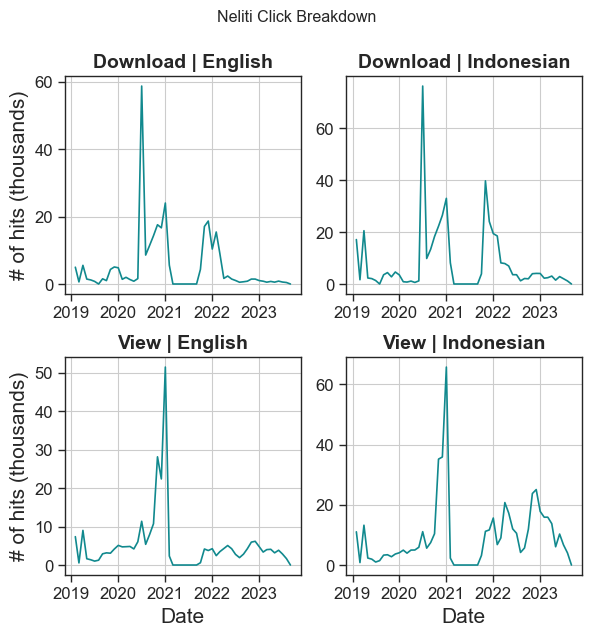

<Figure size 400x400 with 0 Axes>

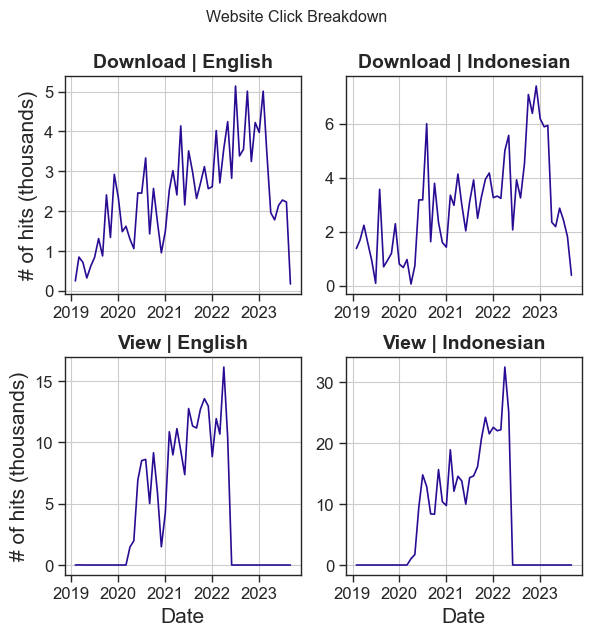

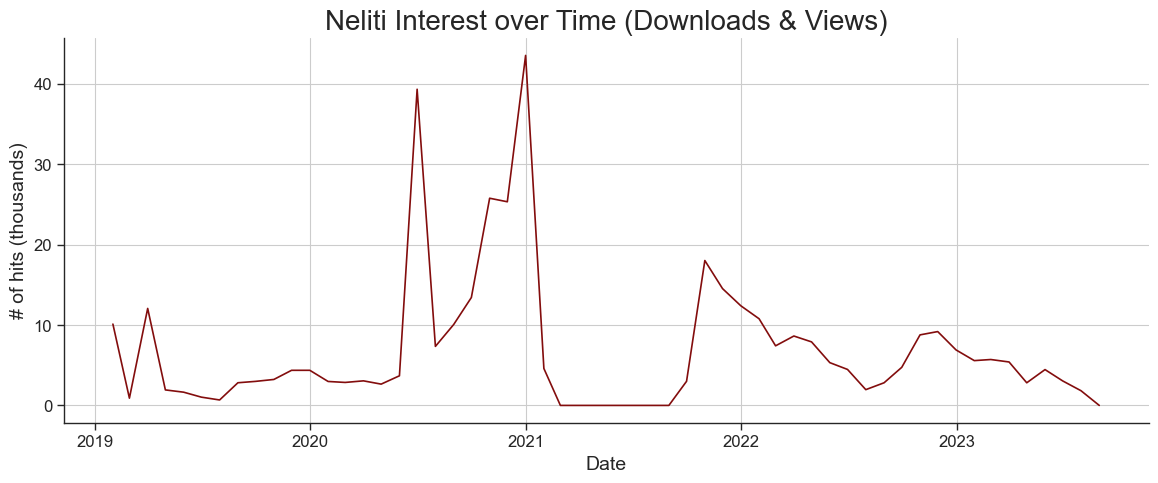

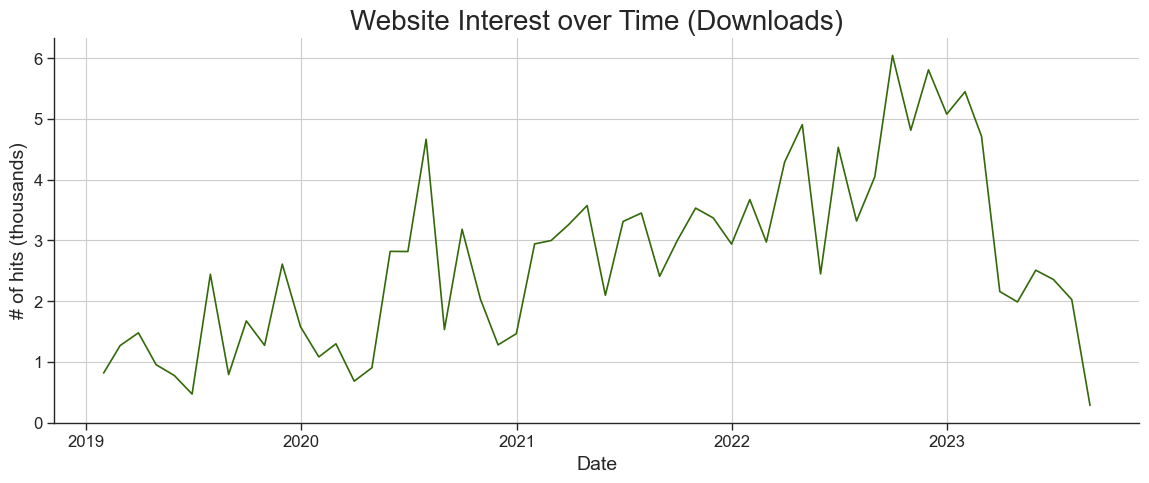

In [11]:
#DATA VIZ AND ANALYSIS

def transform(df):
    plot_df = pd.DataFrame(columns=['Source','Click Type','Language','Title','Type','Topic','Date','# of hits (thousands)'])
    
    for index,row in df.iterrows():
        t = pd.DataFrame({'Source':df.iloc[index,0],'Click Type':df.iloc[index,1],'Language':df.iloc[index,2],
                          'Title':df.iloc[index,3],'Type':df.iloc[index,4],'Topic':df.iloc[index,5],
                          'Date':pd.date_range(start='2019-01-01',end='2023-09-01',freq='M'),
                          '# of hits (thousands)':df.iloc[index,6:62].tolist()})
        
        plot_df = pd.concat([plot_df,t],axis=0,ignore_index=True)
    
    return plot_df

long_clicks = pd.concat([transform(eng_DL),transform(eng_VIEWS),transform(ind_DL),transform(ind_VIEWS)],axis=0,ignore_index=True)

#Neliti FacetGrid
plt.figure(figsize=(4,4))
sns.set_style('ticks',{'axes.grid':True})
graph1 = sns.FacetGrid(long_clicks.loc[long_clicks['Source'] == 'Neliti'],col='Language',row='Click Type',sharex=False,sharey=False)
graph1.map(sns.lineplot,'Date','# of hits (thousands)',ci=None,color='#11898E')
graph1.set_titles(row_template='{row_name}',col_template='{col_name}',fontdict={'size':'35','weight':'bold'})
graph1.set_xlabels(fontdict={'size': 15})
graph1.set_ylabels(fontdict={'size':15})
sns.despine(top=False,right=False)
graph1.fig.suptitle('Neliti Click Breakdown',y=1.05)

#Website FacetGrid
plt.figure(figsize=(4,4))
sns.set_style('ticks',{'axes.grid':True})
graph2 = sns.FacetGrid(long_clicks.loc[long_clicks['Source'] == 'Website'],col='Language',row='Click Type',sharex=False,sharey=False)
graph2.map(sns.lineplot,'Date','# of hits (thousands)',ci=None,color='#2A0B93')
graph2.set_titles(row_template='{row_name}',col_template='{col_name}',fontdict={'size':'35','weight':'bold'})
graph2.set_xlabels(fontdict={'size': 15})
graph2.set_ylabels(fontdict={'size':15})
sns.despine(top=False,right=False)
graph2.fig.suptitle('Website Click Breakdown',y=1.05)

#Neliti Aggregate Linechart
plt.figure(figsize=(14,5))
sns.set_theme(context='paper',style='ticks',palette='dark',rc={'axes.grid':True,'axes.spines.right':False,'axes.spines.top':False,'axes.labelsize':14,'axes.titlesize':20,'xtick.labelsize':12,'ytick.labelsize':12})
graph3 = sns.lineplot(data=long_clicks.loc[long_clicks['Source'] == 'Neliti'],x='Date',y='# of hits (thousands)',color='#830D0D',ci=None)
plt.title('Neliti Interest over Time (Downloads & Views)')

#Website Aggregate Linechart Excluding Views
plt.figure(figsize=(14,5))
sns.set_theme(context='paper',style='ticks',palette='dark',rc={'axes.grid':True,'axes.spines.right':False,'axes.spines.top':False,'axes.labelsize':14,'axes.titlesize':20,'xtick.labelsize':12,'ytick.labelsize':12})
graph4 = sns.lineplot(data=long_clicks.loc[(long_clicks['Source'] == 'Website') & (long_clicks['Click Type'] == 'Download')],x='Date',y='# of hits (thousands)',color='#336909',ci=None)
plt.title('Website Interest over Time (Downloads)')

#Neliti download peak in mid-2020
long_clicks.loc[((long_clicks['Source'] == 'Neliti') & (long_clicks['Click Type'] == 'Download') & (long_clicks['Date'] >= '2020-04') & (long_clicks['Date'] < '2020-12')),['Topic','# of hits (thousands)']].groupby('Topic').sum().sort_values('# of hits (thousands)',ascending=False).rename(columns={'# of hits (thousands)':'Downloads'})

#Neliti view peak in end-2020
long_clicks.loc[((long_clicks['Source'] == 'Neliti') & (long_clicks['Click Type'] == 'View') & (long_clicks['Date'] >= '2020-10') & (long_clicks['Date'] <= '2021-02')),['Topic','# of hits (thousands)']].groupby('Topic').sum().sort_values('# of hits (thousands)',ascending=False).rename(columns={'# of hits (thousands)':'Views'})

#Website download crash in start-2023
long_clicks.loc[((long_clicks['Source'] == 'Website') & (long_clicks['Click Type'] == 'Download') & (long_clicks['Date'] >= '2023-01')),['Topic','# of hits (thousands)']].groupby('Topic').sum().sort_values('# of hits (thousands)',ascending=False).rename(columns={'# of hits (thousands)':'Downloads'})

#Top 10 best performing publications
top_10 = long_clicks.loc[:,['Title','# of hits (thousands)']].groupby('Title').sum().sort_values('# of hits (thousands)',ascending=False).head(10)
top_10.reset_index(inplace=True)
top_10_data = clicks.loc[clicks['Source'] == 'Website'].loc[clicks['Title'].isin(top_10['Title'].tolist()),['Title','Type','Topic']]
top_10_complete = pd.merge(top_10,top_10_data,on='Title',how='inner') 

The mean downloads across topics are NOT significantly different with a p-value of: 0.4827715994467865


C:\Users\Lucas\AppData\Local\Temp\ipykernel_19380\3535369698.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=5)


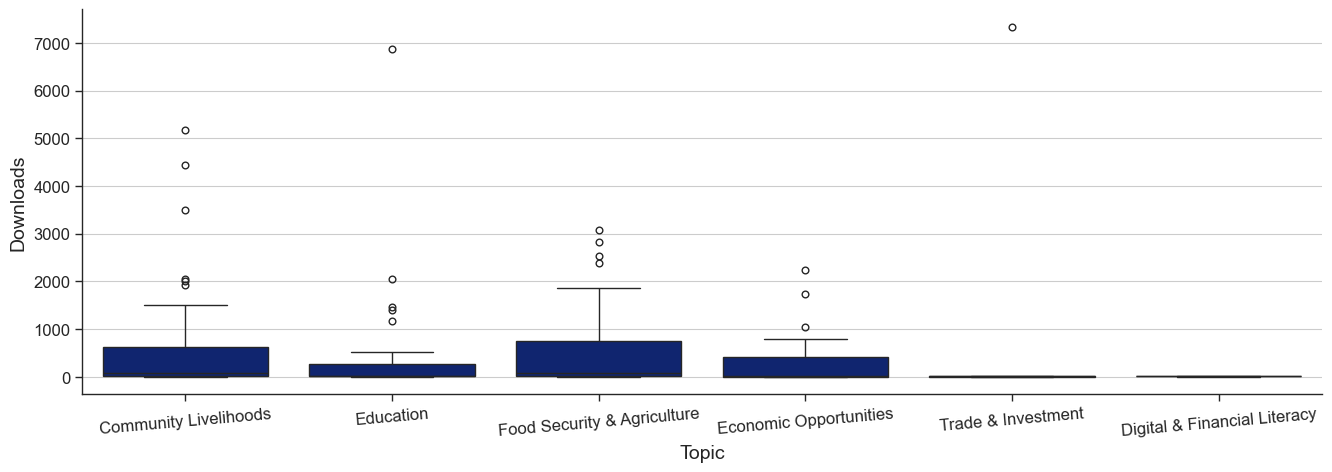

The mean views across topics are NOT significantly different with a p-value of: 0.6020289278391256


C:\Users\Lucas\AppData\Local\Temp\ipykernel_19380\3535369698.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=5)


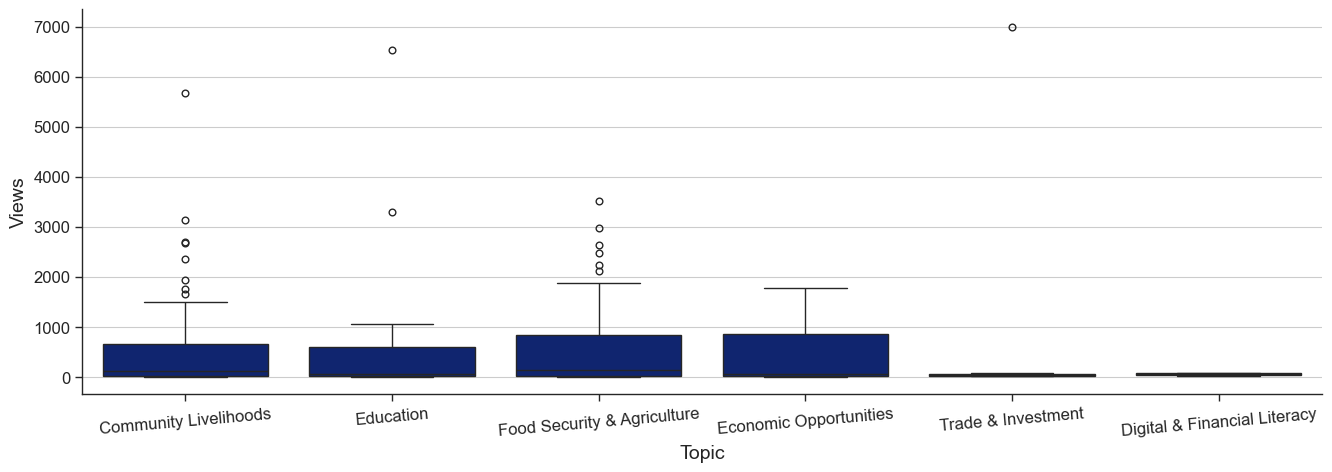

The mean downloads across topics are NOT significantly different with a p-value of: 0.5133524117241541


C:\Users\Lucas\AppData\Local\Temp\ipykernel_19380\3535369698.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(),rotation=5)


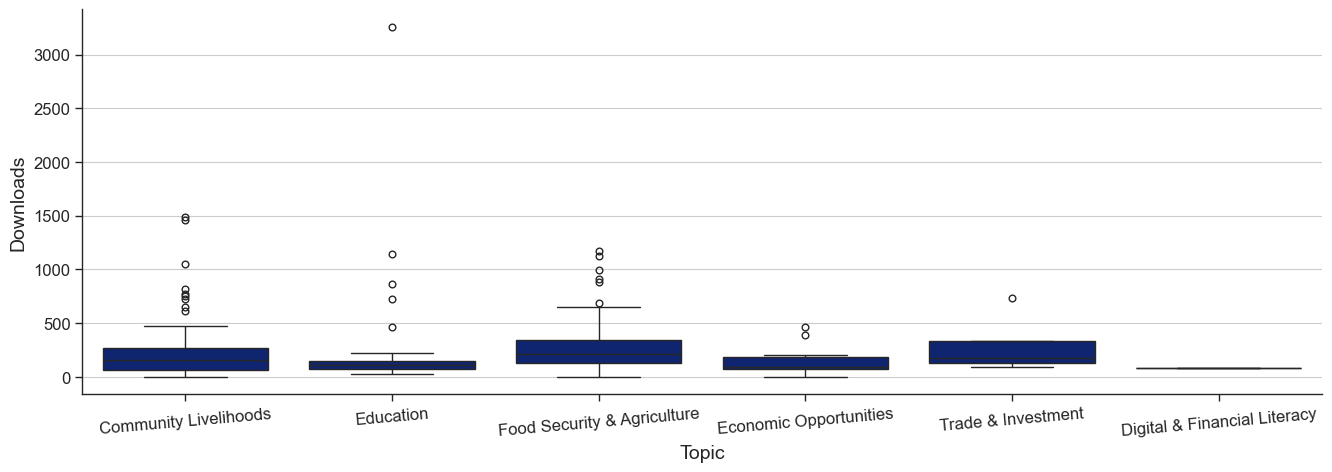

,Topic,Max Values
0,Digital & Financial Literacy,86.500
1,Education,260.875
2,Community Livelihoods,580.500
3,Economic Opportunities,343.000
4,Food Security & Agriculture,665.000
5,Trade & Investment,634.750


In [110]:
#Subsets of interest: Neliti Downloads, Neliti Views, Website Downloads


#TODO: DOUBLE CHECK MAX VALUE CALCULATIONS AND COMPARE WITH BOXPLOT
#TODO: USE MAX VALUES TO COLLECT LIST OF ALL OUTLIER TITLES

def totalitup(df,click_type):
    categories = df.loc[:,['Source','Click Type','Language','Title','Type','Topic']]
    categories[click_type] = df.iloc[:,6:].sum(axis=1)
    #categories = categories.loc[categories[click_type] != 0]
    return categories

all_DL = pd.concat([totalitup(eng_DL,'Downloads'),totalitup(ind_DL,'Downloads')],axis=0,ignore_index=True)
all_VIEWS = pd.concat([totalitup(eng_VIEWS,'Views'),totalitup(ind_VIEWS,'Views')],axis=0,ignore_index=True)

neliti_downloads = all_DL.loc[all_DL['Source'] == 'Neliti']
neliti_views = all_VIEWS.loc[all_VIEWS['Source'] == 'Neliti']
website_downloads = all_DL.loc[all_DL['Source'] == 'Website']

def maxvalues(row,df,clicktype):
    quartile_3 = df.loc[df['Topic'] == row][clicktype].quantile(q=0.75,interpolation='linear')
    quartile_1 = df.loc[df['Topic'] == row][clicktype].quantile(q=0.25,interpolation='linear')
    IQR = quartile_3 - quartile_1
    return quartile_3 + (1.5*IQR)


#Neliti downloads vs Topic - ANOVA
#Null hypothesis: Mean downloads across different topics is the same
nel_dl_categories = neliti_downloads.groupby('Topic')['Downloads'].apply(list)
anova_results = stats.f_oneway(*nel_dl_categories)
if anova_results[1] <= 0.05:
    print("The mean downloads across topics ARE significantly different with a p-value of:",anova_results[1])
elif anova_results[1] > 0.05:
    print("The mean downloads across topics are NOT significantly different with a p-value of:",anova_results[1])

plt.figure(figsize=(16,5))
ax = sns.boxplot(data=neliti_downloads,x='Topic',y='Downloads')
ax.set_xticklabels(ax.get_xticklabels(),rotation=5)
plt.show()

max_nel_dl = pd.DataFrame({'Topic':list(set(neliti_downloads['Topic']))})
max_nel_dl['Max Values'] = max_nel_dl['Topic'].apply(maxvalues,args=(neliti_downloads,'Downloads'))


#Neliti views vs Topic - ANOVA
#Null hypothesis: Mean views across different topics is the same
nel_view_categories = neliti_views.groupby('Topic')['Views'].apply(list)
anova_results = stats.f_oneway(*nel_view_categories)
if anova_results[1] <= 0.05:
    print("The mean views across topics ARE significantly different with a p-value of:",anova_results[1])
elif anova_results[1] > 0.05:
    print("The mean views across topics are NOT significantly different with a p-value of:",anova_results[1])
    
plt.figure(figsize=(16,5))
ax = sns.boxplot(data=neliti_views,x='Topic',y='Views')
ax.set_xticklabels(ax.get_xticklabels(),rotation=5)
plt.show()

max_nel_views = pd.DataFrame({'Topic':list(set(neliti_views['Topic']))})
max_nel_views['Max Values'] = max_nel_views['Topic'].apply(maxvalues,args=(neliti_views,'Views'))



#Website downloads vs Topic - ANOVA
#Null hypothesis: Mean downloads across different topics is the same
web_dl_categories = website_downloads.groupby('Topic')['Downloads'].apply(list)
anova_results = stats.f_oneway(*web_dl_categories)
if anova_results[1] <= 0.05:
    print("The mean downloads across topics ARE significantly different with a p-value of:",anova_results[1])
elif anova_results[1] > 0.05:
    print("The mean downloads across topics are NOT significantly different with a p-value of:",anova_results[1])

plt.figure(figsize=(16,5))
ax = sns.boxplot(data=website_downloads,x='Topic',y='Downloads')
ax.set_xticklabels(ax.get_xticklabels(),rotation=5)
plt.show()

max_web_dl = pd.DataFrame({'Topic':list(set(website_downloads['Topic']))})
max_web_dl['Max Values'] = max_web_dl['Topic'].apply(maxvalues,args=(website_downloads,'Downloads'))

max_web_dl

In [ ]:
#GOOGLE TRENDS KEYWORD ANALYSIS

#Define function for creating list of parsed keywords
def kwsplitter(kw_list):
    #Loops through each row containing a list of keywords then splits the list of keywords based on ', ' and loops through this to return a lower case complete list of all keywords
    full_list = [value.lower() for kw in kw_list for value in kw.split(', ')]
    
    #Returns the keywords as a unique set
    return set(full_list)

#Split keywords into two lists containing Indonesian & English keywords respectively based on the 'Keyword Language' column
#Filter removes the empty elements from the list which is then converted to a list using list()
eng_kw = list(filter(None,kwsplitter(df.loc[df['Keyword Language'] == 'English','Keywords'].tolist())))
ind_kw = list(filter(None,kwsplitter(df.loc[df['Keyword Language'] == 'Indonesian','Keywords'].tolist())))

#Connect to pytrends for English and Indonesian search data
engtrends = TrendReq(hl='en-US',tz=420)
indtrends = TrendReq(hl='id',tz=420)

#Define function for returning Google search popularity of keywords
def gtrends_over_time(kw_list,ref_word,searchlang):
    #Uses the search language parameter of the function to specify the language and timezone of the search data
    if searchlang == 'English':
        trend = engtrends
    elif searchlang == 'Indonesian':
        trend = indtrends
    
    #Initialise empty dataframe and loop counter then begins while loop to run for the length of the keyword list
    trend_df = pd.DataFrame()
    i = 0
    while i < len(kw_list):
        #Slices keyword list based on loop counter and appends the reference word
        l = kw_list[i:(i+4)]
        l.append(ref_word)
        
        #Creates pytrends payload specifying timeframe and geographical region. Assigns result of interest over time to the result variable
        trend.build_payload(l,timeframe='all',geo='ID')
        result = trend.interest_over_time()
        
        #Resets result index and renames duplicate columns
        result.reset_index(inplace=True)
        result.rename(columns={'isPartial':'isPartial'+str(i),ref_word:ref_word+str(i)},inplace=True)
        
        #If first loop, adds result of query to the trend_df dataframe. Second elif statement works because the number of rows stays the same each iteration (number of date entries)
        if len(trend_df.index) == 0:
            trend_df = pd.concat([trend_df,result])
        elif len(trend_df.index) == len(result):
            trend_df = pd.merge(trend_df,result,on='date')
        
        #Adds to loop counter (4 search keywords + 1 reference keyword)
        i += 4
    
    #Return resulting dataframe
    return trend_df